---
# **LAB 4 - CUDA in Python**
---

# ▶️ CUDA setup

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Sun Mar 27 17:31:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |     62MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[GPU Compute Capability](https://developer.nvidia.com/cuda-gpus)

In [ ]:
from numba import cuda

# getting device information
cuda.detect();

Found 1 CUDA devices
id 0            b'Tesla K80'                              [SUPPORTED]
                      compute capability: 3.7
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


In [ ]:
from numba import cuda

attribs = ['COMPUTE_CAPABILITY', 'MULTIPROCESSOR_COUNT', 'MAX_REGISTERS_PER_BLOCK', 
         'MAX_SHARED_MEMORY_PER_BLOCK', ]
device = cuda.get_current_device()
#attribs = [s for s in dir(device) if s.isupper()]        # all attribs
for attr in attribs:
    print(attr, '=', getattr(device, attr))

COMPUTE_CAPABILITY = (3, 7)
MULTIPROCESSOR_COUNT = 13
MAX_REGISTERS_PER_BLOCK = 65536
MAX_SHARED_MEMORY_PER_BLOCK = 49152


In [ ]:
#@title Bash setup
%%writefile /root/.bashrc

# If not running interactively, don't do anything
[ -z "$PS1" ] && return

# don't put duplicate lines in the history. See bash(1) for more options
# ... or force ignoredups and ignorespace
HISTCONTROL=ignoredups:ignorespace

# append to the history file, don't overwrite it
shopt -s histappend

# for setting history length see HISTSIZE and HISTFILESIZE in bash(1)
HISTSIZE=10000
HISTFILESIZE=20000

# check the window size after each command and, if necessary,
# update the values of LINES and COLUMNS.
shopt -s checkwinsize

# make less more friendly for non-text input files, see lesspipe(1)
[ -x /usr/bin/lesspipe ] && eval "$(SHELL=/bin/sh lesspipe)"

PS1='\[\033[01;34m\]\w\[\033[00m\]\$ '

# enable color support of ls and also add handy aliases
if [ -x /usr/bin/dircolors ]; then
    test -r ~/.dircolors && eval "$(dircolors -b ~/.dircolors)" || eval "$(dircolors -b)"
    alias ls='ls --color=auto'
    #alias dir='dir --color=auto'
    #alias vdir='vdir --color=auto'

    alias grep='grep --color=auto'
    alias fgrep='fgrep --color=auto'
    alias egrep='egrep --color=auto'
fi

# some more ls aliases
alias ll='ls -lF'
alias la='ls -A'
alias l='ls -CF'

# path setup
export PATH="./:/usr/local/cuda/bin:$PATH"

!source /root/.bashrc

Overwriting /root/.bashrc


Clone GPUcomputing site on github...

In [ ]:
!git clone https://github.com/giulianogrossi/GPUcomputing.git

fatal: destination path 'GPUcomputing' already exists and is not an empty directory.


# 🐍 Add kernel

In [ ]:
from numba import cuda
import numpy as np

In [ ]:
# CUDA kernels written with `@cuda.jit` do not return values
@cuda.jit
def add_kernel(x, y, z):
  """Perform vector sum z = x * y
  """
    
  # The actual values of the following CUDA-provided variables for thread and block indices,
  # like function parameters, are not known until the kernel is launched.
  
  # This calculation gives a unique thread index within the entire grid (see the slides above for more)
  idx = cuda.grid(1)      # 1 = one dimensional thread grid, returns a single value.
                          # This Numba-provided convenience function is equivalent to
                          # `cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x`

  # This thread will do the work on the data element with the same index as its own
  # unique index within the grid.
  z[idx] = x[idx] + y[idx]

Define the kernel parameters...

In [ ]:
# Because of how we wrote the kernel above, we need to have a 1 thread to one data element mapping,
# therefore we define the number of threads in the grid (128*32) to equal n (4096).
threads_per_block = 128
blocks_per_grid = 32

Generate data and device setup/transfert...

In [ ]:
# populate data
n = 4096
x = np.arange(n).astype(np.int32) # [0...4095] on the host
y = np.ones_like(x)               # [1...1] on the host

d_x = cuda.to_device(x) # Copy of x on the device
d_y = cuda.to_device(y) # Copy of y on the device
d_out = cuda.device_array_like(d_x) # Like np.array_like, but for device arrays


launch the kernel...

In [ ]:
%%time
add_kernel[blocks_per_grid, threads_per_block](d_x, d_y, d_out)
cuda.synchronize()
print(d_out.copy_to_host()) # Should be [1...4096]

[   1    2    3 ... 4094 4095 4096]
CPU times: user 263 ms, sys: 160 ms, total: 423 ms
Wall time: 532 ms


# 🐍 Mat multiplication kernel

In [ ]:
from numba import cuda
import numpy as np

In [ ]:
@cuda.jit
def matmul_gpu(A, B, C):
  """Perform square matrix multiplication of C = A * B
  """

  row, col = cuda.grid(2)
  if row < C.shape[0] and col < C.shape[1]:
    tmp = 0.
    for k in range(A.shape[1]):
      tmp += A[row, k] * B[k, col]
    C[row, col] = tmp

# matrix multiplication using the cpu and C-like programming style (** strongly discouraged **)
def matmul_cpu(A, B):
  """Perform square matrix multiplication of C = A * B
  """
  C = np.zeros((A.shape[1],B.shape[1]))
  for i in range(A.shape[1]):
    for j in range(B.shape[0]):
      tmp = 0.                            
      for k in range(A.shape[1]):
        tmp += A[i, k] * B[k, j]   # multiply elements in row i of A and column j of B and add to temp
      C[i, j] = tmp    

In [ ]:
# generate random vals
np.random.seed(42)
SIZE = 1000
A = np.ones((SIZE,SIZE)).astype('float32')  # mat 1
B = np.ones((SIZE,SIZE)).astype('float32')  # mat 2
C = np.zeros((SIZE,SIZE)).astype('float32')                       # mat where we store answer 

d_A = cuda.to_device(A) # Copy of A on the device
d_B = cuda.to_device(B) # Copy of B on the device
d_C = cuda.device_array_like(A) # malloc on the device

# data type
d_A.dtype

dtype('float32')

In [ ]:
!nvidia-smi

Sun Mar 27 13:39:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |     83MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(C)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Kernel parameters...

In [ ]:
block = (16, 16)  # each block will contain 16x16 threads, typically 128 - 512 threads/block
grid_x = int(np.ceil(C.shape[0] / block[0]))
grid_y = int(np.ceil(C.shape[1] / block[1]))
grid = (grid_x, grid_y)  # we calculate the gridsize (number of blocks) from array
print(grid)
print(f"The kernel will be executed up to element {block[0]*grid_x}")

(63, 63)
The kernel will be executed up to element 1008


In [ ]:
%%time
# execution of the kernel
matmul_gpu[grid, block](d_A, d_B, d_C)
cuda.synchronize()

CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 182 ms


In [ ]:
C = d_C.copy_to_host()
print(C)

[[1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 ...
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]]


In [ ]:
%%time
# execution of the python function in C-like programming style (strongly discouraged)
D = matmul_cpu(A, B)

CPU times: user 8min 48s, sys: 1.42 s, total: 8min 50s
Wall time: 8min 50s


In [ ]:
%%time
# execution of the kernel
C = np.dot(A, B)

In [ ]:
print(C)

# 🐍 Histogram

In [ ]:
from numba import cuda
import numpy as np

## 🔴 TODO

In [ ]:
@cuda.jit
def BMP_hist(I, H):
  row, col = cuda.grid(2)
  if row < I.shape[0] and col < I.shape[1]:
      rgb = I[row, col]
      H[0, rgb[0]] += 1
      H[1, rgb[1]] += 1
      H[2, rgb[2]] += 1


## Gestione immagine e kernel...

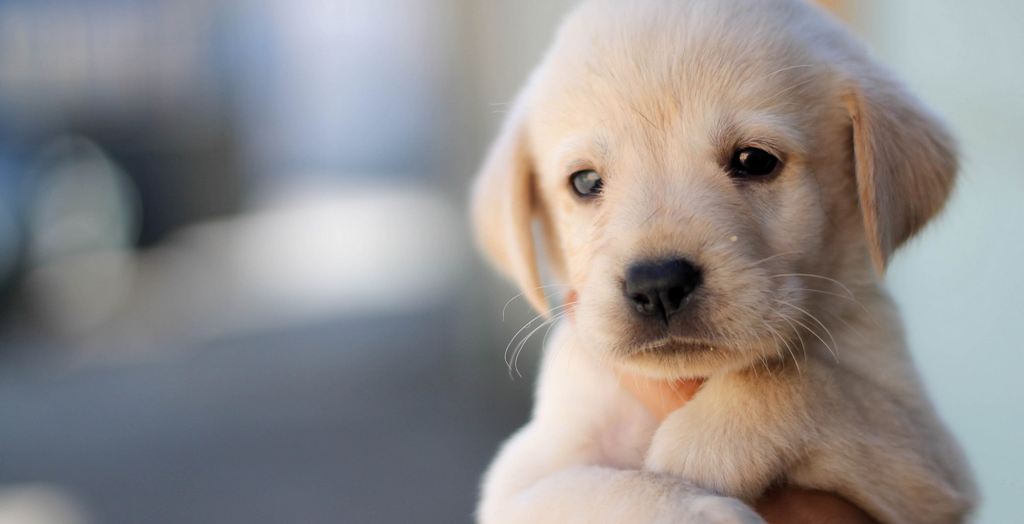

In [ ]:
from PIL import Image

#image.save('beach1.bmp')
img = Image.open('GPUcomputing/images/dog.bmp')
img_rgb = img.convert('RGB')
img_rgb

In [ ]:
# converto to numpy (host)
I = np.asarray(img)
print(f"Image size W x H x ch = {I.shape}")

# device data setup
d_I = cuda.to_device(I)
H = np.zeros((3,256)).astype(np.float32)
d_H = cuda.to_device(H)

Image size W x H x ch = (524, 1024, 3)


Kernel parameters...

In [ ]:
block = (16, 16)  # each block will contain 16x16 threads, typically 128 - 512 threads/block
grid_x = int(np.ceil(I.shape[0] / block[0]))
grid_y = int(np.ceil(I.shape[1] / block[1]))
grid = (grid_x, grid_y)  # we calculate the gridsize (number of blocks) from array
print(grid)
print(f"The kernel will be executed up to element {block[0]*grid_x}")

(33, 64)
The kernel will be executed up to element 528


In [ ]:
# kernel launch

BMP_hist[grid, block](d_I, d_H)
hist = d_H.copy_to_host()
print(hist.shape)

(3, 256)


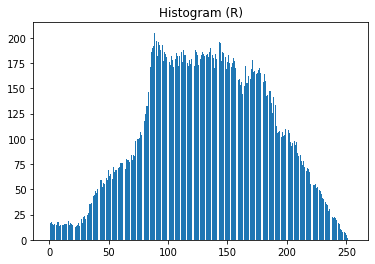

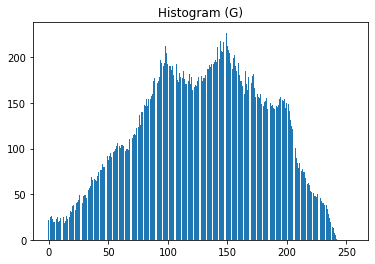

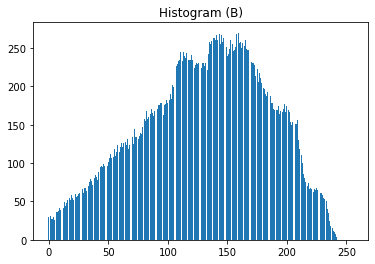

In [ ]:
import matplotlib.pyplot as plt

plt.bar(np.arange(256),hist[0])
plt.title('Histogram (R)')
plt.show()
plt.bar(np.arange(256),hist[1])
plt.title('Histogram (G)')
plt.show()
plt.bar(np.arange(256),hist[2])
plt.title('Histogram (B)')
plt.show()

# 🔴 TODO

Calcolare il prodotto di matrici MQDB con kernel CUDA in Python

In [ ]:
import numpy as np
import random
from numba import cuda



#n = dimension of the matrix
#k = number of submatrices
#const_ro_rand = how to fill the submatrices
#const_value = the constant value (if needed)
def generate_mqdb(n, k, const_or_rand, const_value = 0):
  mat = np.zeros((n,n))

  sub_dims = []

  tmp = 0
  remaining_values = k
  for i in range(k-1):
    curr_subdim = random.randint(1, n-remaining_values+1 - tmp)
    sub_dims.append(curr_subdim)
    for j in range(tmp, tmp + curr_subdim):
      for k in range(tmp, tmp + curr_subdim):  
        if const_or_rand == "C":
          mat[j,k] = const_value
        else: 
          mat[j,k] = random.uniform(0,1)
        
    tmp += curr_subdim
    remaining_values -= 1

  final_dim = n - tmp
  sub_dims.append(final_dim)
  for j in range(tmp, tmp + final_dim):
    for k in range(tmp, tmp + final_dim):  
      if const_or_rand == "C":
        mat[j,k] = const_value
      else: 
         mat[j,k] = random.uniform(0,1)

  return (mat, sub_dims)


class my_mqdb:
  def __init__(self, n, k, const_or_rand, const_value = 0):
    (self.mat, self.sub_matrices_dims) = generate_mqdb(n,k, const_or_rand, const_value)


#A,B = input matrices
#C = output matrices
#cur_k = dimension of the current submatrix
#offset = from where to start the calculus
@cuda.jit
def BMP_hist(I, H):
  row, col = cuda.grid(2)
  if row < I.shape[0] and col < I.shape[1]:
      rgb = I[row, col]
      H[0, rgb[0]] += 1
      H[1, rgb[1]] += 1
      H[2, rgb[2]] += 1

@cuda.jit
def mqdb_smart(A, B, C, cur_k, offset):
  x, y = cuda.grid(2)
  x += offset
  y += offset
  
  if x < cur_k and y < cur_k:
    sum = 0
    for l in range(offset, offset + cur_k):
      sum += A.mat[x, y+l] * B.mat[x+l, y]
    C[x,y] = sum

@cuda.jit
def mqdb_smart_2(A, B, C, cur_k, offset):
  x, y = cuda.grid(2)
  x += offset
  y += offset
  
  if x < cur_k and y < cur_k:
    sum = 0
    for l in range(offset, offset + cur_k):
      sum += A[x, y+l] * B[x+l, y]
    C[x,y] = sum


#A = my_mqdb(100,4,"C", 5)
#B = my_mqdb(100,4,"C", 5)
#B.mat = np.copy(A.mat)
#B.sub_matrices_dims = A.sub_matrices_dims

A, k_arr = generate_mqdb(100,4,"C", 5)
B = np.copy(A)

d_A = cuda.to_device(A)
d_B = cuda.to_device(B)
d_C = cuda.device_array_like(A)



block = (16, 16)  # each block will contain 16x16 threads, typically 128 - 512 threads/block
off = 0

for elem in A.sub_matrices_dims:
  grid_x = int(np.ceil(elem / block[0]))
  grid_y = int(np.ceil(elem / block[1]))
  grid = (grid_x, grid_y)
  print(grid)
  mqdb_smart_2[grid, block](d_A, d_B, d_C, elem, off)
  off += elem

C = d_C.copy_to_host()
print(C)

(6, 6)


TypingError: ignored